<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/04_Named_Entity_Recognition/KAZU.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>

# KAZU (Korea AstraZeneca University)

## 1. Introduction


[KAZU](https://github.com/AstraZeneca/KAZU) (Korea AstraZeneca University) is a scalable open source biomedical NLP pipelining framework built by AstraZeneca and Korea University to handle production workloads and support BioNLP for
the pharmaceutical sector. KAZU is built around a computationally efficient version of the BERN2 NER model (TinyBERN2), and subsequently wraps several other BioNLP technologies into one coherent system for BioNER and linking to assist the drug discovery/development process in projects such as the [Biological Insights Knowledge Graph](https://www.biorxiv.org/content/10.1101/2021.10.28.466262v1.full) (BIKG).


To account for the rapid pace of NLP development, KAZU has been designed in a modular pipeline fashion, wherein new algorithms can be introduced relatively easily, for example a module to perform [NER using an LLM](https://astrazeneca.github.io/KAZU/_autosummary/kazu.steps.ner.llm_ner.html#module-kazu.steps.ner.llm_ner) has been added. In addition to TinyBERN2, it includes distillated PubMedBERT ([Gu et al., 2021](https://dl.acm.org/doi/10.1145/3458754)), components
for abbreviation expansion ([Neumann et al., 2019](https://doi.org/10.18653/v1/W19-5034)),
entity linking ([Liu et al., 2020](http://arxiv.org/abs/2010.11784)), and additional novel algorithms.

As outlined in the research paper ([Yoon, W. et al., 2022](https://aclanthology.org/2022.emnlp-industry.63.pdf)), the KAZU model architecture addresses problems such as nested entities and generalisability. Historically, BioNER models used a single-label classification approach tokenising a string of text and assigning each token a label by calculating the probabilities of whether the token is the
beginning, inside or outside (BIO) of named entities. However, this approach cannot properly predict nested entities where the spans of multiple types of entities are overlapped. KAZU mitigates this by applying multi-label label prediction for each token. There is also support for non-contiguous entities, prevalent in biomedical literature.

TinyBERN2 addresses generalisability issues, or concerns about the ability to predict unseen entities that are not in the training dataset, by utilising a weakly supervised learning strategy and soft labelling (i.e. training with
the confidence values of the supervising model) for entity classes rather than traditional binary or hard labelling (i.e. training with the categorical
labels produced by the supervising model) which can hinder weakly labelled training by adding biases.

## 2. Install/import libraries

In [ ]:
!pip install spacy scispacy

In [ ]:
# scispaCy small model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import requests
import spacy
import scispacy
import re
import warnings
warnings.filterwarnings("ignore")

from multiprocessing.pool import ThreadPool
from time import sleep
from collections import Counter
from spacy import displacy
from spacy.tokens import Doc
from spacy import util
from spacy.language import Language
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker

## 3. KAZU API

To install KAZU for use in production systems refer to the [documentation](https://astrazeneca.github.io/KAZU/index.html).

Here we will use the [Web API](http://kazu.korea.ac.kr/api/docs#/) designed for light usage. The endpoint for NER and Linking in version 2.0 is http://kazu.korea.ac.kr/api/kazu/ner_and_linking although the earlier version 1.0 was originally used, with endpoint http://kazu.korea.ac.kr/kazu/ner_and_linking.



We will define a function to call the API endpoint and perform NER and Linking for some test sentences.

In [ ]:
def query_kazu(text: str):
    """Biomedical entity linking API"""

    # KAZU API for cloud service

    url="http://kazu.korea.ac.kr/api/kazu/ner_and_linking"

    if isinstance(text, str):
        response = requests.post(url, json={'text': text}).json()
        sleep(1)
    else:
      raise TypeError("Need to supply text")

    return response

In [ ]:
def get_entities(text: str):

    entity_list = []

    for sentence in text:
        entity_list.append(query_kazu(sentence))

    return entity_list

### 3.1 NER and Linking

We will test using the same two sentences which had nested entities when extracted by BERN2 for comparison.

In [ ]:
data = {
    'text': [["In the context of the pandemic in that year, there was a surge in research on the subject, with COVID-19/SARS-CoV-2/Coronavirus topping the list of keywords as soon as COVID-19/SARS-CoV-2/Coronavirus appeared that year.", "We used gene expression profiles of SARS-CoV-2 infected samples and a control group from alveolar type II cells and African green monkey kidney cells."]]
}

In [ ]:
test_df = pd.DataFrame(data, columns=['text'])
test_df

,text
0,"[In the context of the pandemic in that year, ..."


In [ ]:
%%time

with ThreadPool(4) as pool:
    entity_list = pool.map(get_entities, test_df.text)

CPU times: user 16.3 ms, sys: 1.12 ms, total: 17.5 ms
Wall time: 977 ms


In [ ]:
entity_list

[[[{'idx': '40155ed2601040e6b7546035c3106a76',
    'sections': [{'text': 'In the context of the pandemic in that year, there was a surge in research on the subject, with COVID-19/SARS-CoV-2/Coronavirus topping the list of keywords as soon as COVID-19/SARS-CoV-2/Coronavirus appeared that year.',
      'name': 'na',
      'entities': [{'match': 'COVID-19',
        'entity_class': 'disease',
        'spans': [{'start': 96, 'end': 104}],
        'namespace': 'MemoryEfficientStringMatchingStep',
        'start': 96,
        'end': 104,
        'match_norm': 'COVID-19',
        'mention_confidence': 'PROBABLE',
        'mappings': [{'default_label': 'COVID-19',
          'source': 'MONDO',
          'parser_name': 'OPENTARGETS_DISEASE',
          'idx': 'MONDO_0100096',
          'string_match_strategy': 'ExactMatchMappingStrategy',
          'string_match_confidence': 'HIGHLY_LIKELY',
          'disambiguation_strategy': 'disambiguation_not_required',
          'metadata': {'dbXRefs': ['MES

The output is in JSON format for each sentence and uses a hashing algorithm to compute the value for the 'idx' key so we do not have to perform this as an extra step as for BERN2.  The output also contains the match, entity class, start and end spans, canonical name and mappings/entity linking information including the ontology mapped to, the parser, CUI, string matching strategy and confidence, disambiguation strategy if this was required, and cross references.

The documentation provides more information about the [OntologyParser](https://astrazeneca.github.io/KAZU/ontology_parser.html), and the [challenges of entity linking](https://astrazeneca.github.io/KAZU/introduction.html) such as overlapping ontologies and inconsistencies of knowledge bases and ontologies. Rather than depending on a composite system like UMLS, KAZU links directly to the source ontology URIs.

Datasets and models used are listed on the [KAZU repo](https://github.com/AstraZeneca/KAZU?tab=readme-ov-file#dataset-licences) and include popular standard datasets commonly used in drug discovery such as ChEMBL for drug compounds, Mondo for diseases, the Gene Ontology for genes, and others.







### 3.2 Visualise NER labels

We will use spaCy's displaCy named entity visualiser with custom colours for the entity types to highlight the named entities and their labels.

In [ ]:
colors = {'disease': 'linear-gradient(90deg, #66ffcc, #abf763)',
          'drug': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)',
          "gene":'linear-gradient(90deg, #ffff66, #ff6600)',
          'species': 'linear-gradient(90deg, #6699ff, #99ccff)',
          'cell_line': 'linear-gradient(90deg, #ff99cc, #ffcccc)',
          'cell_type': 'linear-gradient(90deg, #99ff99, #66ff66)'}

In [ ]:
def get_entities_html(entity_list, title=None, colors=None):
    """Visualise NER with the help of spaCy"""
    render_data_list = []
    options = {"colors": colors} if colors else {}

    for sublist in entity_list:
        for item in sublist:
            ents = []
            entities = item[0].get('sections', [{}])[0].get('entities', [])  # Accessing the 'entities' list inside 'sections'
            for entity in entities:
                start = entity['spans'][0]['start'] if 'spans' in entity and entity['spans'] else None
                end = entity['spans'][0]['end'] if 'spans' in entity and entity['spans'] else None
                label = entity['entity_class'] if 'entity_class' in entity else None
                if start is not None and end is not None and label is not None:
                    ents.append({"start": start, "end": end, "label": label})

            text = item[0].get('sections', [{}])[0].get('text', None)  # Accessing the 'text' value inside 'sections'
            render_data = {"text": text, "ents": ents, "title": title}
            render_data_list.append(render_data)

    displacy.render(render_data_list, style="ent", manual=True, jupyter=True, options=options)

In [ ]:
test_parsed_entities_html = get_entities_html(entity_list, colors=colors)

This is more accurate than BERN2 insofar as 'African green monkey kidney cells' appears correctly as a merged entity without the nested entities 'African green' and 'African green monkey'.
Also, 'SARS-CoV-2' in the second sentence appears correctly without nested entity 'SARS-CoV'.

However, if we compare it with the BERN2 output for the same sentences below, the same issue occurs in the first sentence with the first mention of 'SARS-CoV-2' not being fully captured and 'Coronavirus' not identified at all.



In [ ]:
# BERN2 output for same two sentences
entities_html = get_entities_html(entity_list)

### 3.3 NER and Linking for 10 articles

We will extract the named entities and labels for coreference resolved text for 10 articles.

In [ ]:
# load data for 10 articles
with open('2024-03-24_pmc_arxiv_full_sent_text_spacy_fastcoref_sent_tok_0_10_df.pickle', 'rb') as f:
    coref_sent_tok_0_10_df = pickle.load(f)

In [ ]:
coref_sent_tok_0_10_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       10 non-null     object
 1   published        10 non-null     object
 2   revised          10 non-null     object
 3   title            10 non-null     object
 4   journal          10 non-null     object
 5   authors          10 non-null     object
 6   doi              10 non-null     object
 7   pdf_url          10 non-null     object
 8   text             10 non-null     object
 9   sent_text        10 non-null     object
 10  coref_text       10 non-null     object
 11  sent_coref_text  10 non-null     object
dtypes: object(12)
memory usage: 1.1+ KB


We will call the API endpoint to perform NER and Linking on 10 articles. The function below uses the legacy version 1.0 with endpoint http://kazu.korea.ac.kr/kazu/ner_and_linking.

In [ ]:
def query_kazu(text: str):
    """Biomedical entity linking API"""

    # KAZU API for cloud service

    url="http://kazu.korea.ac.kr/kazu/ner_and_linking"

    if isinstance(text, str):
        response = requests.post(url, json={'text': text}).json()
        sleep(1)
    else:
      raise TypeError("Need to supply text")

    return response

In [ ]:
def get_entities(text: str):

    entity_list = []

    for sentence in text:
        entity_list.append(query_kazu(sentence))

    return entity_list

In [ ]:
%%time

with ThreadPool(4) as pool:
     entity_list = pool.map(get_entities, coref_sent_tok_0_10_df.sent_coref_text)
with open('2024-03-26_kazu_entity_list_coref_sent_tok_0_10_df.pickle', 'wb') as f:
  pickle.dump(entity_list, f)

CPU times: user 13.8 s, sys: 1.97 s, total: 15.7 s
Wall time: 17min 59s


In [ ]:
len(entity_list)

10

In [ ]:
# JSON output for first article
entity_list[0]

[[{'idx': '9fac46a65c684e9cb308f8056b185981',
   'sections': [{'text': 'Sir James Black, a winner of the 1988 Nobel Prize, clearly recognized well before the 21st century that drug repurposing strategies would occupy an important place in the future of new drug discovery.',
     'name': 'na'}]}],
 [{'idx': '52630635919f4fc09eed777af5df84cd',
   'sections': [{'text': 'In 2004, Ted T. Ashburn et al. summarized previous research and developed a general approach to drug development using drug repurposing, retrospectively looking for new indications for approved drugs and molecules that are waiting for approval for new pathways of action and targets.',
     'name': 'na'}]}],
 [{'idx': 'dac90fc1831b4b84a654152c8bb6b60a',
   'sections': [{'text': 'molecules that are waiting for approval for new pathways of action and targets are usually safe in clinical trials but do not show sufficient efficacy for the treatment of the disease originally targeted.',
     'name': 'na'}]}],
 [{'idx': '5414c43c

### 3.4 Parsed entities

The following function accesses the 'entities' list inside 'sections', then the 'idx' value, or CUI, from the first element in the 'mappings' list for the entity if available, else it returns the entity mention.  Start and end spans are also accessed from the 'spans' list.

In [ ]:
def get_parsed_entities_kazu(entity_list):
    parsed_entities = []
    for item in entity_list:
        entities = item[0].get('sections', [{}])[0].get('entities', [])  # Accessing the 'entities' list inside 'sections'
        for entity in entities:
            if 'mappings' in entity:  # Checking if 'mappings' key exists
                entity_id = entity['mappings'][0]['idx']  # Accessing the 'idx' value from the first element of 'mappings' list
            else:
                entity_id = entity.get('match')
            spans_list = entity.get('spans', [])  # Accessing the 'spans' list from the entity dictionary
            span_start = spans_list[0].get('start')
            span_end = spans_list[0].get('end')
            parsed_entities.append({
                'entity_id': entity_id,
                'entity_type': entity.get('entity_class'),
                'entity': entity.get('match'),
                'span_start': span_start,
                'span_end': span_end,
                'text': item[0].get('sections', [{}])[0].get('text'),  # Accessing the 'text' value inside 'sections'
                'idx': item[0].get('idx')
            })
    return parsed_entities

In [ ]:
parsed_entities = list(map(get_parsed_entities_kazu, entity_list))

In [ ]:
len(parsed_entities)

10

In [ ]:
with open('2024-04-03_kazu_entity_list_entities_only_spans_0_10.pickle', 'wb') as f:
  pickle.dump(parsed_entities, f)

In [ ]:
parsed_entities[0]

[{'entity_id': 'CHEMBL192',
  'entity_type': 'drug',
  'entity': 'sildenafil',
  'span_start': 38,
  'span_end': 48,
  'text': 'Since the 1990s, the repositioning of sildenafil for male erectile dysfunction and pulmonary hypertension, the development of a new efficacy of bupropion for smoking cessation, new applications of thalidomide for multiple myeloma, and chronic graft-versus-host disease have generated intense interest from pharmaceutical companies and academics.',
  'idx': '22200652f00d4d5fb5875f619734eaed'},
 {'entity_id': 'http://purl.obolibrary.org/obo/HP_0100639',
  'entity_type': 'disease',
  'entity': 'male erectile dysfunction',
  'span_start': 53,
  'span_end': 78,
  'text': 'Since the 1990s, the repositioning of sildenafil for male erectile dysfunction and pulmonary hypertension, the development of a new efficacy of bupropion for smoking cessation, new applications of thalidomide for multiple myeloma, and chronic graft-versus-host disease have generated intense interest

### 3.5 Entities only

We will iterate over the list of parsed entities for each article, append the data to a list and convert it to a DataFrame.

In [ ]:
entities_only_list = []

for article in parsed_entities:
    for entity in article:
        entities_only_list.append({
            'entity_id': entity['entity_id'],
            'entity_type': entity['entity_type'],
            'entity': entity['entity'],
            'span_start': entity['span_start'],
            'span_end': entity['span_end'],
            'text': entity['text'],
            'idx': entity['idx']
        })

entities_only_df = pd.DataFrame(entities_only_list, columns=['entity_id', 'entity_type', 'entity', 'span_start', 'span_end', 'text', 'idx'])

In [ ]:
entities_only_df

,entity_id,entity_type,entity,span_start,span_end,text,idx
0,CHEMBL192,drug,sildenafil,38,48,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed
1,http://purl.obolibrary.org/obo/HP_0100639,disease,male erectile dysfunction,53,78,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed
2,MONDO_0005149,disease,pulmonary hypertension,83,105,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed
3,CHEMBL894,drug,bupropion,144,153,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed
4,CHEMBL468,drug,thalidomide,197,208,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed
...,...,...,...,...,...,...,...
3384,CMAP,gene,CMAP,116,120,"To compare our method with other methods, we u...",1def003b39ea4c6dbe9a5f73b7600a69
3385,SARS-CoV-2,species,SARS-CoV-2,36,46,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9
3386,http://purl.obolibrary.org/obo/CL_0002063,cell_type,alveolar type II cells,89,111,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9
3387,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9


In [ ]:
with open('2024-04-03_kazu_entity_list_entities_only_spans_df_0_10.pickle', 'wb') as f:
  pickle.dump(entities_only_df, f)

In [ ]:
entities_only_df.to_csv('2024-04-03_kazu_entity_list_entities_only_spans_df_0_10.csv', index=False)

### 3.6 CUI-less entities only

We will filter for the CUI-less entities where entity_id is the entity name to see how many knowledge base ids are missing.




In [ ]:
missing_entity_id_df = entities_only_df[entities_only_df['entity_id'] == entities_only_df['entity']]

In [ ]:
len(missing_entity_id_df)

1113

In [ ]:
with open('2024-04-06_missing_entity_id_df.pickle', 'wb') as f:
   pickle.dump(missing_entity_id_df, f)

In [ ]:
missing_entity_id_df

,entity_id,entity_type,entity,span_start,span_end,text,idx
9,Cmap,gene,Cmap,98,102,Computational drug repositioning relies on pub...,ff1c074b8c7a4d15805ef2ab4f043bb1
34,SARS,species,SARS,68,72,the top 30 most used author keywords include f...,e8adbb3eb77941f9bd063708854ffb17
35,Coronavirus,disease,Coronavirus,79,90,the top 30 most used author keywords include f...,e8adbb3eb77941f9bd063708854ffb17
41,Statins,drug,Statins,58,65,"Drug names appear four times, Antiviral drugs,...",7814d19035cf414fa7a2268c1ed0376d
44,SARS-CoV-,disease,SARS-CoV-,105,114,"In the context of the pandemic in that year, t...",650b870a0f1e4bd089a385567180c322
...,...,...,...,...,...,...,...
3358,NCBI,gene,NCBI,117,121,We got differentially expressed genes of all t...,10a9092bf2a6475b89583c244d12e1dc
3364,viral,disease,viral,46,51,Since drugs can directly or indirectly affect ...,bc958fd093674d4c899ca04e37df63e0
3384,CMAP,gene,CMAP,116,120,"To compare our method with other methods, we u...",1def003b39ea4c6dbe9a5f73b7600a69
3385,SARS-CoV-2,species,SARS-CoV-2,36,46,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9


In [ ]:
missing_entity_id_df.to_csv('2024-04-06_missing_entity_id.csv', index=False)

In [ ]:
# convert missing entity ids to list
all_missing_entity_id = missing_entity_id_df.entity.tolist()
all_missing_entity_id

['Cmap',
 'SARS',
 'Coronavirus',
 'Statins',
 'SARS-CoV-',
 'SARS-CoV-2',
 'Coronavirus',
 'SARS-',
 'Coronavirus',
 'coronavirus',
 'SARS-CoV-2',
 'p97 segregase',
 'nCoV',
 'SARS-',
 '3D cell culture',
 'genetically related diseases',
 'COVID‐19',
 'Coronaviruses CoVs',
 'epidemic diseases',
 'CoVs',
 'COVID‐19',
 'SARS‐CoV',
 'respiratory illness',
 'SARS‐CoV',
 'COVID‐19',
 'SARS‐CoV‐2',
 'SARS‐CoV‐2',
 'phosphoramide',
 'phosphate',
 'COVID‐19',
 'COVID',
 'SARS‐CoV',
 'SARS',
 'CADD',
 'SARS',
 'COVID',
 'SARS',
 'paxlovid 3c‐like protease',
 'COVID‐19',
 'SARS‐CoV',
 'COVID‐19',
 'COVID',
 'SARS',
 'COVID‐19',
 'COVID‐19',
 'COVID‐19',
 'SARS',
 'SARS',
 'pp1ab',
 'host cells',
 '3CLpro',
 'papain',
 'papain',
 'replicase complex',
 'papain',
 'PLpro',
 'papain',
 'SARS',
 'ZINC',
 'SARS‐CoV‐2',
 'Mpro',
 'SARS',
 'SARS',
 'SARS‐CoV',
 'COVID‐19',
 'SARS‐CoV',
 'S',
 'SARS‐CoV‐2',
 'COVID',
 'SARS',
 'human coronavirus papain‐like proteases',
 'SARS‐Coronavirus',
 'SARS',
 'COV

A lot of COVID-related entities e.g. COVID, COVID-19, SARS-CoV-2 and variations not being mapped to a kb.

In [ ]:
with open('2024-04-06_missing_entity_id_list_1113.pickle', 'wb') as f:
  pickle.dump(all_missing_entity_id, f)

In [ ]:
# count for each missing entity id
counter = Counter(all_missing_entity_id).most_common()

In [ ]:
counter

[('SARS-CoV-2', 174),
 ('NSP-12', 64),
 ('SARS', 33),
 ('COVID‐19', 32),
 ('RdRp', 23),
 ('SARS‐CoV', 18),
 ('RdRp domain', 18),
 ('Lagevrio', 15),
 ('NS5B', 15),
 ('HCV', 15),
 ('SARS‐CoV‐2', 14),
 ('COVID', 11),
 ('N', 11),
 ('SARS-CoV', 11),
 ('SARS-CoV-', 10),
 ('MERS-CoV', 10),
 ('spike glycoprotein', 10),
 ('EIDD-1931', 9),
 ('6NUR', 9),
 ('M9', 8),
 ('CoVs', 7),
 ('Mpro', 7),
 ('C', 7),
 ('CMAP', 7),
 ('RBD', 6),
 ('S protein', 6),
 ('HCoV', 6),
 ('RNA-dependent RNA polymerase RdRp', 6),
 ('GTP', 6),
 ('SARS-', 5),
 ('coronavirus', 5),
 ('papain', 5),
 ('RNA-dependent RNA polymerase', 5),
 ('CoV', 5),
 ('NSP6 SARS-CoV-2', 5),
 ('Coronavirus', 4),
 ('ZINC', 4),
 ('human cells', 4),
 ('CVL218', 4),
 ('mice', 4),
 ('nucleoside', 4),
 ('RNA-dependent DNA polymerase', 4),
 ('COVID-19 infections', 4),
 ('CMap', 4),
 ('inflammation', 4),
 ('UTP', 4),
 ('host cells', 3),
 ('3CLpro', 3),
 ('SARSCoV-2', 3),
 ('envelope', 3),
 ('3-chymotrypsin-like', 3),
 ('SARS CoV-2', 3),
 ('spike glycop

It appears as though the same entities are appearing more than once (e.g.SARS-CoV-2) which suggests formatting issues.

In [ ]:
with open('2024-04-06_missing_entity_id_unique_424.pickle', 'wb') as f:
  pickle.dump(counter, f)

In [ ]:
unique_entities = list(set(all_missing_entity_id))

In [ ]:
len(unique_entities)

424

In [ ]:
with open('2024-04-06_missing_entity_id_unique_list_424.pickle', 'wb') as f:
  pickle.dump(unique_entities, f)

## 4. scispaCy

We will build a scispaCy pipeline, add AbbreviationDetector and EntityLinker components, and perform a lookup using the UMLS linker for missing CUIs.

### 4.1 AbbreviationDetector

In [ ]:
# Load small English scispaCy model
nlp = spacy.load("en_core_sci_sm")

In [ ]:
# add abbreviation_detector component
nlp.add_pipe("abbreviation_detector")

In [ ]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'parser',
 'ner',
 'abbreviation_detector']

### 4.2 EntityLinker

In [ ]:
nlp.add_pipe("scispacy_linker", config={"linker_name": "umls", "resolve_abbreviations": True})

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmp9fw7xqe_


100%|██████████| 492M/492M [00:13<00:00, 36.9MiB/s]


Finished download, copying /tmp/tmp9fw7xqe_ to cache at /root/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmpmaf7hycq


100%|██████████| 724M/724M [00:21<00:00, 35.2MiB/s]


Finished download, copying /tmp/tmpmaf7hycq to cache at /root/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpif_fc2sc


100%|██████████| 1.32M/1.32M [00:00<00:00, 3.25MiB/s]


Finished download, copying /tmp/tmpif_fc2sc to cache at /root/.scispacy/datasets/37bc06bb7ce30de7251db5f5cbac788998e33b3984410caed2d0083187e01d38.f0994c1b61cc70d0eb96dea4947dddcb37460fb5ae60975013711228c8fe3fba.tfidf_vectorizer.joblib
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/concept_aliases.json not found in cache, downloading to /tmp/tmpw8nh2nx9


100%|██████████| 264M/264M [00:09<00:00, 30.4MiB/s]


Finished download, copying /tmp/tmpw8nh2nx9 to cache at /root/.scispacy/datasets/6238f505f56aca33290aab44097f67dd1b88880e3be6d6dcce65e56e9255b7d4.d7f77b1629001b40f1b1bc951f3a890ff2d516fb8fbae3111b236b31b33d6dcf.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2023-04-23/umls_2022_ab_cat0129.jsonl not found in cache, downloading to /tmp/tmpm7a93sev


100%|██████████| 628M/628M [00:17<00:00, 38.1MiB/s]


Finished download, copying /tmp/tmpm7a93sev to cache at /root/.scispacy/datasets/d5e593bc2d8adeee7754be423cd64f5d331ebf26272074a2575616be55697632.0660f30a60ad00fffd8bbf084a18eb3f462fd192ac5563bf50940fc32a850a3c.umls_2022_ab_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmpw3ek_nvk


100%|██████████| 4.26k/4.26k [00:00<00:00, 5.71MiB/s]

Finished download, copying /tmp/tmpw3ek_nvk to cache at /root/.scispacy/datasets/21a1012c532c3a431d60895c509f5b4d45b0f8966c4178b892190a302b21836f.330707f4efe774134872b9f77f0e3208c1d30f50800b3b39a6b8ec21d9adf1b7.umls_semantic_type_tree.tsv


In [ ]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'parser',
 'ner',
 'abbreviation_detector',
 'scispacy_linker']

We will convert the missing entity ids into spacy Doc objects.

In [ ]:
def get_missing(docs):
    missing_list = []
    docs = nlp.pipe(docs)
    missing_list.append(list(docs))
    return missing_list

In [ ]:
%%time

missing_doc_list = get_missing(unique_entities)

CPU times: user 2.58 s, sys: 84.3 ms, total: 2.66 s
Wall time: 2.83 s


In [ ]:
missing_doc_list

[[Tinospora cordifolia,
  enterovirus A71,
  TPCA-1,
  COVID-,
  SARS,
  eridictoyl,
  SARS-CoV-,
  human lung cell line,
  LEU207,
  HCoV,
  Mn2+,
  CoV-infected,
  envelopes E,
  papain-like protease N 19,
  eucalyptus,
  HIV,
  aloe,
  adenoviruses,
  NS5B,
  M46,
  HCoV-OC43 Human Coronavirus,
  anyone,
  nidovirus,
  RNA Dependent RNA Polymerases RdRp,
  RNA-dependent RNA polymerases RdRp,
  polymerases,
  Phe347,
  human-derived cells,
  Arg6817,
  infected cells,
  in vitro cell line,
  mice,
  MHC Class II receptor,
  Arg346,
  Lagevrio,
  M9,
  hemagglutinin,
  Asp286,
  SARS‐3CL protease,
  ORF7a,
  Apo NSP-12,
  Mg2+,
  viral,
  REGN10989,
  E484,
  M44's,
  COVID-19 viral infections,
  Human,
  yeast,
  Asn422,
  nonstructural protein NSP,
  Phe286,
  seasonal flu,
  systemic inflammatory response syndrome SIRS,
  Phe314,
  African green monkey kidney cells,
  host cells,
  RdRp,
  MERS corona virus,
  Gastrointestinal complaints,
  Gln498,
  SB-201290,
  SARS‐CoV‐2,
  Val4

In [ ]:
with open('2024-04-06_all_missing_doc_list_424.pickle', 'wb') as f:
  pickle.dump(missing_doc_list, f)

#### 4.2.1 Querying knowledge base entries - UMLS

We will query the knowledge base for more detail by retrieving the `EntityLinker` component from the pipeline using the `get_pipe()` method. We can then access the entity definition by looking up the CUI in the `linker.kb.cui_to_entity` dictionary using the CUI as the key.  




In [ ]:
linker = nlp.get_pipe("scispacy_linker")

In [ ]:
def get_detailed_kb_ents(docs):
    kb_ent_list = []
    for index, doc in enumerate(docs):
        entities = doc.ents
        for entity in entities:
            if entity._.kb_ents:  # Check if kb_ents is not empty
                first_cuid = entity._.kb_ents[0][0]
                kb_entry = linker.kb.cui_to_entity[first_cuid]
                kb_ent_list.append(f"{entity.text}, {first_cuid}, {kb_entry.canonical_name}, {kb_entry.definition}")
    return kb_ent_list

In [ ]:
%%time

detailed_missing_kb_ents = list(map(get_detailed_kb_ents, missing_doc_list))

CPU times: user 5.22 ms, sys: 1.78 ms, total: 7 ms
Wall time: 6.96 ms


In [ ]:
detailed_missing_kb_ents

[['Tinospora cordifolia, C1501208, Tinospora cordifolia, None',
  'enterovirus, C0014378, Enterovirus Infections, Diseases caused by ENTEROVIRUS.',
  'TPCA-1, C1567717, 2-((aminocarbonyl)amino)-5-(4-fluorophenyl)-3-thiophenecarboxamide, None',
  'SARS, C1175175, Severe Acute Respiratory Syndrome, A viral respiratory infection caused by the SARS coronavirus. It is transmitted through close person-to-person contact. It is manifested with high fever, headache, dry cough and myalgias. It may progress to pneumonia and cause death.',
  'SARS-CoV-, C5203676, SARS-CoV-2, A positive-sense single-stranded RNA virus in the genus Betacoronavirus. It is the causative agent of the 2019-2020 severe acute respiratory syndrome outbreak.',
  'human, C0086418, Homo sapiens, Members of the species Homo sapiens.',
  'envelopes E, C4528946, Envelopes, Flat paper containers used to protect objects or paperwork during storage or transport. Items are placed inside the envelope, which is then typically sealed s

In [ ]:
for i in detailed_missing_kb_ents:
    print(len(i))

287


In [ ]:
with open('2024-04-06_detailed_missing_kb_ents.pickle', 'wb') as f:
   pickle.dump(detailed_missing_kb_ents, f)

### 4.3 scispaCy NER

We will create Doc objects from a couple of sentences and extract entities and spans.

In [ ]:
text = """In the context of the pandemic in that year, there was a surge in research on the subject, with COVID-19/SARS-CoV-2/Coronavirus topping the list of keywords as soon as COVID-19/SARS-CoV-2/Coronavirus appeared that year.
In addition, A SARS-CoV-2 protein interaction map reveals targets for drug repurposing, published in Nature by Gordon, DE with a total of 125 scholars from the United States, the United Kingdom, and France was the most cited publication with 952 citations."""

In [ ]:
doc = nlp(text)

In [ ]:
list(doc.sents)

[In the context of the pandemic in that year, there was a surge in research on the subject, with COVID-19/SARS-CoV-2/Coronavirus topping the list of keywords as soon as COVID-19/SARS-CoV-2/Coronavirus appeared that year.,
 In addition, a SARS-CoV-2 protein interaction map reveals targets for drug repurposing, published in Nature by Gordon, DE with a total of 125 scholars from the United States, the United Kingdom, and France was the most cited publication with 952 citations.]

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

pandemic 22 30 ENTITY
year 39 43 ENTITY
surge 57 62 ENTITY
research 66 74 ENTITY
subject 82 89 ENTITY
COVID-19/SARS-CoV-2/Coronavirus 96 127 ENTITY
topping 128 135 ENTITY
keywords 148 156 ENTITY
COVID-19/SARS-CoV-2/Coronavirus 168 199 ENTITY
year 214 218 ENTITY
SARS-CoV-2 protein interaction 235 265 ENTITY
targets 278 285 ENTITY
drug repurposing 290 306 ENTITY
published 308 317 ENTITY
Nature 321 327 ENTITY
Gordon 331 337 ENTITY
DE 339 341 ENTITY
scholars 362 370 ENTITY
United States 380 393 ENTITY
United Kingdom 399 413 ENTITY
France 419 425 ENTITY
publication 445 456 ENTITY
citations 466 475 ENTITY


'COVID-19/SARS-CoV-2/Coronavirus' is treated as one entity.

## 5. spaCy

We will try the same again with spaCy to see if the three are indentified as separate entities.

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = nlp(text)

In [ ]:
list(doc.sents)

[In the context of the pandemic in that year, there was a surge in research on the subject, with COVID-19/SARS-CoV-2/Coronavirus topping the list of keywords as soon as COVID-19/SARS-CoV-2/Coronavirus appeared that year.,
 In addition, a SARS-CoV-2 protein interaction map reveals targets for drug repurposing, published in Nature by Gordon, DE with a total of 125 scholars from the United States, the United Kingdom, and France was the most cited publication with 952 citations.]

#### 5.1 spaCy NER

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

that year 34 43 DATE
COVID-19 96 104 ORG
COVID-19 168 176 ORG
that year 209 218 DATE
Nature 321 327 WORK_OF_ART
Gordon 331 337 PERSON
125 358 361 CARDINAL
the United States 376 393 GPE
the United Kingdom 395 413 GPE
France 419 425 GPE
952 462 465 CARDINAL


spaCy only recognises 'COVID-19' from 'COVID-19/SARS-CoV-2/Coronavirus' from the first sentence, and does not recognise 'SARS-CoV-2' or 'SARS-CoV-2 protein interaction' from the second sentence.

### 5.2 spaCy custom component

We will create a custom pipeline component to implement a rule-based strategy using regex pattern matching for different COVID-related entities.

In [ ]:
# convert sentence tokenised coref text to list
all_article_text = coref_sent_tok_0_10_df.sent_coref_text.tolist()

In [ ]:
# Adapted from https://github.com/librairy/bio-ner/blob/main/bionlp/NER_processing.py

@Language.component("postprocessing_covid")
def expand_covid_ents(doc):
    """Post-processing component to expand COVID-related entities in a spaCy document.

    :param doc: spacy.Doc, the input spaCy document

    :return: The modified spaCy document with expanded COVID-related entities.
    """
    pattern_sars = r"((sarsr?|mers|severe\sacute\srespiratory\ssyndrome|\b(?:\w+?-covs?|n(?:covs?)|2019-ncov|covs?|\b(?:[A-Za-z]+-)?[Hh]Co[Vv](?:-[A-Za-z]+)?\b)\b)(\s?\-?\s?(covs?))?(\s?\-?\s?2)?(\s?\binfe.{1,10}?\b)?)"
    pattern_covid = r"((covid)(\s?\-?\s?(19))?(\s?\binfe.{1,10}?\b)?)"
    pattern_coronavirus = r"((coronavir.{0,6}?\b)(\s?\bpneumo.{0,8}?\b)?(\s?\binfe.{1,10}?\b)?(\s?\bdiseas.{1,6}?\b)?(\s?\-?\s?(20)?(19))?)"
    pattern_variant_lineage = r"(\b[A-Z]{1}\.\d{1,4}(\.\d{1,4}){0,4}\b)"

    patterns_covid = [{"label": "disease", "pattern": pattern_sars, "id": "covid"},
                      {"label": "disease", "pattern": pattern_covid, "id": "covid"},
                      {"label": "disease", "pattern": pattern_coronavirus, "id": "covid"},
                      {"label": "covid lineage", "pattern": pattern_variant_lineage, "id": "covid"}]

    new_ents = []
    doc_ents = list(doc.ents)
    for pattern in patterns_covid:
        for match in re.finditer(pattern['pattern'], doc.text, re.IGNORECASE):
            start, end = match.span()
            span = doc.char_span(start, end, label=pattern['label'], kb_id=pattern['id'], alignment_mode='expand')
            # This is a Span object or None if match doesn't map to valid token sequence
            if span is not None:
                new_ents.append(span)
    ents = doc_ents + new_ents
    filtered_spans = util.filter_spans(ents)
    doc.set_ents(filtered_spans)
    return doc

In [ ]:
nlp = spacy.load("en_core_web_sm", exclude=["tok2vec", "lemmatizer"])

In [ ]:
# add custom component to pipeline
nlp.add_pipe('postprocessing_covid', before='ner')

<function __main__.expand_covid_ents(doc)>

In [ ]:
nlp.pipe_names

['tagger', 'parser', 'attribute_ruler', 'postprocessing_covid', 'ner']

In [ ]:
def get_docs(docs):
    doc_list = []
    docs = nlp.pipe(docs)
    doc_list.append(list(docs))
    return doc_list

In [ ]:
%%time

doc_list = list(map(get_docs, all_article_text))

CPU times: user 11 s, sys: 547 ms, total: 11.5 s
Wall time: 15.1 s


In [ ]:
len(doc_list)

10

In [ ]:
with open('2024-04-22_articles_0-10_doclist_web_sm.pickle', 'wb') as f:
   pickle.dump(doc_list, f)

In [ ]:
# flatten the doc list using list comprehension
flattened_doc_list = [item for sublist in doc_list for item in sublist]

In [ ]:
with open('2024-04-22_articles_0-10_flattened_doclist_web_sm.pickle', 'wb') as f:
   pickle.dump(flattened_doc_list, f)

We will define a function to iterate over the Doc objects and append the entity, spans, label (`disease` or `covid lineage`), knowledge base id (set to 'covid' in the `expand_covid_ents` function) and the text where the entity is mentioned.

In [ ]:
def get_covid_ents(docs):
    covid_ent_list = []
    for index, doc in enumerate(docs):
        for ent in doc.ents:
            if ent.label_ in ["disease", "covid lineage"]:
                covid_ent_list.append(f"{ent.text}, {ent.start_char}, {ent.end_char},  {ent.label_}, {ent.kb_id_}, {doc.text}")
    return covid_ent_list

In [ ]:
covid_ents_only = list(map(get_covid_ents, flattened_doc_list))

In [ ]:
len(covid_ents_only)

10

In [ ]:
covid_ents_only

[['COVID-19, 197, 205,  disease, covid, The number of annual publications has been increasing at a relatively high rate since 2015, while in 2020, there was a spike in the number of publications and annual citations, probably due to the COVID-19 pandemic, a global public health emergency that prompted special attention from scientists.',
  'COVID-19, 59, 67,  disease, covid, the top 30 most used author keywords include five diseases COVID-19/SARS-CoV-2/Coronavirus, Cancer, Alzheimer’s disease, Breast cancer, and Chagas disease.',
  'SARS-CoV-2, 68, 78,  disease, covid, the top 30 most used author keywords include five diseases COVID-19/SARS-CoV-2/Coronavirus, Cancer, Alzheimer’s disease, Breast cancer, and Chagas disease.',
  'Coronavirus, 79, 90,  disease, covid, the top 30 most used author keywords include five diseases COVID-19/SARS-CoV-2/Coronavirus, Cancer, Alzheimer’s disease, Breast cancer, and Chagas disease.',
  'COVID-19, 96, 104,  disease, covid, In the context of the pandem

In [ ]:
# print the number of COVID entities matched in each article
for i in covid_ents_only:
    print(len(i))

29
150
70
198
64
82
49
234
89
192


In [ ]:
with open('2024-04-22_articles_0-10_covid_ents_only_web_sm_1157.pickle', 'wb') as f:
   pickle.dump(covid_ents_only, f)

We will define function to iterate over the COVID entities doc list, extract the entity_id, entity_type, entity, spans and text, and return a list of dictionaries.

In [ ]:
def get_covid_ents(docs):
    covid_ent_list = []
    for index, doc in enumerate(docs):
        for ent in doc.ents:
            if ent.label_ in ["disease", "covid lineage"]:
                entity_dict = {
                    "entity_id":ent.kb_id_,
                    "entity_type": ent.label_,
                    "entity": ent.text,
                    "span_start": ent.start_char,
                    "span_end": ent.end_char,
                    "text": doc.text
                }
                covid_ent_list.append(entity_dict)
    return covid_ent_list

In [ ]:
covid_ents_only = list(map(get_covid_ents, flattened_doc_list))

In [ ]:
len(covid_ents_only)

10

In [ ]:
covid_ents_only

[[{'entity_id': 'covid',
   'entity_type': 'disease',
   'entity': 'COVID-19',
   'span_start': 197,
   'span_end': 205,
   'text': 'The number of annual publications has been increasing at a relatively high rate since 2015, while in 2020, there was a spike in the number of publications and annual citations, probably due to the COVID-19 pandemic, a global public health emergency that prompted special attention from scientists.'},
  {'entity_id': 'covid',
   'entity_type': 'disease',
   'entity': 'COVID-19',
   'span_start': 59,
   'span_end': 67,
   'text': 'the top 30 most used author keywords include five diseases COVID-19/SARS-CoV-2/Coronavirus, Cancer, Alzheimer’s disease, Breast cancer, and Chagas disease.'},
  {'entity_id': 'covid',
   'entity_type': 'disease',
   'entity': 'SARS-CoV-2',
   'span_start': 68,
   'span_end': 78,
   'text': 'the top 30 most used author keywords include five diseases COVID-19/SARS-CoV-2/Coronavirus, Cancer, Alzheimer’s disease, Breast cancer, and Cha

In [ ]:
with open('2024-04-22_articles_0-10_covid_ents_only_plus_text_web_sm_dict_1157.pickle', 'wb') as f:
   pickle.dump(covid_ents_only, f)

## 6. Postprocessing

We will add article_id as a key to the entity_list originally extracted by the API for all 10 articles.

In [ ]:
# load dataset with article_id column
with open('2024-03-24_pmc_arxiv_full_sent_text_spacy_fastcoref_sent_tok_0_10_df.pickle', 'rb') as f:
    coref_sent_tok_0_10_df = pickle.load(f)

In [ ]:
coref_sent_tok_0_10_df.article_id.head(10)

0    PMC9549161
1    PMC9539342
2    PMC9357751
3    PMC9346052
4    PMC9775208
5    PMC9527439
6    PMC9729590
7    PMC9236981
8    PMC9694939
9    PMC9556799
Name: article_id, dtype: object

In [ ]:
# load entity_list extracted by the API for 10 articles
with open('2024-03-26_kazu_entity_list_coref_sent_tok_0_10_df.pickle', 'rb') as f:
    entity_list = pickle.load(f)

In [ ]:
len(entity_list)

10

Define function to add article_id to entity_list for all sentences.

In [ ]:
def add_article_id_all(entity_list, df):
    modified_sents_list = []
    for i, article_data in enumerate(entity_list):
        article_id = df.iloc[i]['article_id']
        modified_article_data = []  # Initialise modified data for the current article
        for sentence in article_data:
            sentence[0]['article_id'] = article_id
            modified_article_data.append(sentence[0])
        modified_sents_list.append(modified_article_data)
    return modified_sents_list

In [ ]:
all_sents_article_id = add_article_id_all(entity_list, coref_sent_tok_0_10_df)

In [ ]:
len(all_sents_article_id)

10

In [ ]:
with open('2024-04-19_articles_0-10_all_kazu_sents_article_id.pickle', 'wb') as f:
   pickle.dump(all_sents_article_id, f)

We will define a function to return a list of dictionaries with text, idx and article_id for all sentences, and entity_id, entity_type, entity, and spans where available.

In [ ]:
def get_parsed_sents_kazu(entity_list):
    parsed_sents_nested = []  # Initialise an empty list to store nested lists of sentences for each article
    for article in entity_list:
        article_id = article[0].get('article_id')  # Get the article_id
        parsed_sents = []  # Initialise an empty list to store sentences for the current article
        for item in article:
            section = item.get('sections', [{}])[0]  # Accessing the first section, or an empty dictionary if no sections exist
            entities = section.get('entities', [])  # Accessing the 'entities' list inside 'sections'
            if not entities:  # If no entities found in the section, append the sentence without entity details
                parsed_sents.append({
                    'entity_id': None,
                    'entity_type': None,
                    'entity': None,
                    'span_start': None,
                    'span_end': None,
                    'text': section.get('text'),
                    'idx': item.get('idx'),
                    'article_id': article_id
                })
            else:
                for entity in entities:
                    if 'mappings' in entity:  # Checking if 'mappings' key exists
                        entity_id = entity['mappings'][0]['idx']  # Accessing the 'idx' value from the first element of 'mappings' list
                    else:
                        entity_id = entity.get('match')
                    spans_list = entity.get('spans', [])  # Accessing the 'spans' list from the entity dictionary
                    span_start = spans_list[0].get('start') if spans_list else None
                    span_end = spans_list[0].get('end') if spans_list else None
                    parsed_sents.append({
                        'entity_id': entity_id,
                        'entity_type': entity.get('entity_class'),
                        'entity': entity.get('match'),
                        'span_start': span_start,
                        'span_end': span_end,
                        'text': section.get('text'),  # Accessing the 'text' value inside 'sections'
                        'idx': item.get('idx'),
                        'article_id': article_id
                    })
        parsed_sents_nested.append(parsed_sents)  # Append the list of sentences for the current article to the nested list
    return parsed_sents_nested

In [ ]:
parsed_sents_nested = get_parsed_sents_kazu(all_sents_article_id)

In [ ]:
len(parsed_sents_nested)

10

In [ ]:
with open('2024-04-19_articles_0-10_kazu_all_parsed_sents_nested.pickle', 'wb') as f:
   pickle.dump(parsed_sents_nested, f)

We will flatten the nested list of dictionaries and create a DataFrame for all sentences in the dataset.

In [ ]:
# Flatten the nested list of dictionaries
flattened_list = [item for sublist in parsed_sents_nested for item in sublist]

In [ ]:
# Create a DataFrame from the flattened list
kazu_all_sents_df = pd.DataFrame(flattened_list)

In [ ]:
kazu_all_sents_df

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
0,None,None,None,NaN,NaN,"Sir James Black, a winner of the 1988 Nobel Pr...",9fac46a65c684e9cb308f8056b185981,PMC9549161
1,None,None,None,NaN,NaN,"In 2004, Ted T. Ashburn et al. summarized prev...",52630635919f4fc09eed777af5df84cd,PMC9549161
2,None,None,None,NaN,NaN,molecules that are waiting for approval for ne...,dac90fc1831b4b84a654152c8bb6b60a,PMC9549161
3,None,None,None,NaN,NaN,The definition of the term drug repurposing ha...,5414c43c91a64d44845916fad4efc2fc,PMC9549161
4,None,None,None,NaN,NaN,It should be pointed out that the synonyms of ...,27742cffa2c54fc49702f702c306630a,PMC9549161
...,...,...,...,...,...,...,...,...
4553,African green monkey kidney cells,cell_type,African green monkey kidney cells,116.0,149.0,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799
4554,None,None,None,NaN,NaN,We input the top-50 up- and downregulated gene...,6fe83ef06b55422a8319ee57eb628c91,PMC9556799
4555,http://purl.obolibrary.org/obo/MONDO_0100096,disease,COVID-19,67.0,75.0,We take as ground truth all drugs currently in...,af85dcd07def41358eaa7a59139350c1,PMC9556799
4556,None,None,None,NaN,NaN,Then we computed the receiver operating charac...,6b6a938cf2af46149b1a6583b47e58bb,PMC9556799


In [ ]:
kazu_all_sents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4558 entries, 0 to 4557
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   entity_id    3389 non-null   object 
 1   entity_type  3389 non-null   object 
 2   entity       3389 non-null   object 
 3   span_start   3389 non-null   float64
 4   span_end     3389 non-null   float64
 5   text         4558 non-null   object 
 6   idx          4558 non-null   object 
 7   article_id   4558 non-null   object 
dtypes: float64(2), object(6)
memory usage: 285.0+ KB


Spans have been converted to floats instead of integers due to the fact that `NaN` values are floats and you cannot have these in an `int` column. We will convert the span_start and span_end columns into [nullable integer data types](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html).

In [ ]:
# Convert 'span_start' and 'span_end' columns to nullable integer type
kazu_all_sents_df['span_start'] = kazu_all_sents_df['span_start'].astype('Int64')
kazu_all_sents_df['span_end'] = kazu_all_sents_df['span_end'].astype('Int64')

In [ ]:
kazu_all_sents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4558 entries, 0 to 4557
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3389 non-null   object
 1   entity_type  3389 non-null   object
 2   entity       3389 non-null   object
 3   span_start   3389 non-null   Int64 
 4   span_end     3389 non-null   Int64 
 5   text         4558 non-null   object
 6   idx          4558 non-null   object
 7   article_id   4558 non-null   object
dtypes: Int64(2), object(6)
memory usage: 293.9+ KB


In [ ]:
kazu_all_sents_df

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
0,None,None,None,<NA>,<NA>,"Sir James Black, a winner of the 1988 Nobel Pr...",9fac46a65c684e9cb308f8056b185981,PMC9549161
1,None,None,None,<NA>,<NA>,"In 2004, Ted T. Ashburn et al. summarized prev...",52630635919f4fc09eed777af5df84cd,PMC9549161
2,None,None,None,<NA>,<NA>,molecules that are waiting for approval for ne...,dac90fc1831b4b84a654152c8bb6b60a,PMC9549161
3,None,None,None,<NA>,<NA>,The definition of the term drug repurposing ha...,5414c43c91a64d44845916fad4efc2fc,PMC9549161
4,None,None,None,<NA>,<NA>,It should be pointed out that the synonyms of ...,27742cffa2c54fc49702f702c306630a,PMC9549161
...,...,...,...,...,...,...,...,...
4553,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799
4554,None,None,None,<NA>,<NA>,We input the top-50 up- and downregulated gene...,6fe83ef06b55422a8319ee57eb628c91,PMC9556799
4555,http://purl.obolibrary.org/obo/MONDO_0100096,disease,COVID-19,67,75,We take as ground truth all drugs currently in...,af85dcd07def41358eaa7a59139350c1,PMC9556799
4556,None,None,None,<NA>,<NA>,Then we computed the receiver operating charac...,6b6a938cf2af46149b1a6583b47e58bb,PMC9556799


In [ ]:
with open('2024-04-19_articles_0-10_kazu_all_sents_4558_df.pickle', 'wb') as f:
   pickle.dump(kazu_all_sents_df, f)

We will define a function to update the list of dictionaries of COVID entities by adding 'article_id' and 'idx' keys.

In [ ]:
# load COVID entities only dataset
with open('2024-04-22_articles_0-10_covid_ents_only_plus_text_web_sm_dict_1157.pickle', 'rb') as f:
   covid_ents_only = pickle.load(f)

In [ ]:
# load parsed sentences dataset for all 10 articles
with open('2024-04-19_articles_0-10_kazu_all_parsed_sents_nested.pickle', 'rb') as f:
   parsed_sents_nested = pickle.load(f)

In [ ]:
def match_and_append_idx(first_data, second_data):
    # Initialise a dictionary to store text and idx mappings from the second dataset
    text_idx_map = {item['text']: {'idx': item['idx'], 'article_id': item['article_id']} for sublist in second_data for item in sublist}

    # Iterate through the first dataset and match text with idx from the second dataset
    for sublist in first_data:
        for item in sublist:
            text = item['text']
            if text in text_idx_map:
                matched_item = text_idx_map[text]
                item['idx'] = matched_item['idx']
                item['article_id'] = matched_item['article_id']

    return first_data

In [ ]:
updated_spacy_data =  match_and_append_idx(covid_ents_only, parsed_sents_nested)

In [ ]:
len(updated_spacy_data)

10

In [ ]:
# COVID entities dictionaries updated with idx and article_id
updated_spacy_data

[[{'entity_id': 'covid',
   'entity_type': 'disease',
   'entity': 'COVID-19',
   'span_start': 197,
   'span_end': 205,
   'text': 'The number of annual publications has been increasing at a relatively high rate since 2015, while in 2020, there was a spike in the number of publications and annual citations, probably due to the COVID-19 pandemic, a global public health emergency that prompted special attention from scientists.',
   'idx': '487f27b9fd2446438765e1a7f6a96952',
   'article_id': 'PMC9549161'},
  {'entity_id': 'covid',
   'entity_type': 'disease',
   'entity': 'COVID-19',
   'span_start': 59,
   'span_end': 67,
   'text': 'the top 30 most used author keywords include five diseases COVID-19/SARS-CoV-2/Coronavirus, Cancer, Alzheimer’s disease, Breast cancer, and Chagas disease.',
   'idx': 'e8adbb3eb77941f9bd063708854ffb17',
   'article_id': 'PMC9549161'},
  {'entity_id': 'covid',
   'entity_type': 'disease',
   'entity': 'SARS-CoV-2',
   'span_start': 68,
   'span_end': 78,
 

In [ ]:
with open('2024-04-22_articles_0-10_covid_ents_only_plus_text_idx_article_id_1157', 'wb') as f:
   pickle.dump(updated_spacy_data, f)

We will flatten the nested list of dictionaries and create a DataFrame for all sentences in the COVID entities dataset.

In [ ]:
# Flatten the nested list of dictionaries
flattened_list = [item for sublist in updated_spacy_data for item in sublist]

In [ ]:
# Create a DataFrame from the flattened list
covid_ents_only_df = pd.DataFrame(flattened_list)

In [ ]:
covid_ents_only_df

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
0,covid,disease,COVID-19,197,205,The number of annual publications has been inc...,487f27b9fd2446438765e1a7f6a96952,PMC9549161
1,covid,disease,COVID-19,59,67,the top 30 most used author keywords include f...,e8adbb3eb77941f9bd063708854ffb17,PMC9549161
2,covid,disease,SARS-CoV-2,68,78,the top 30 most used author keywords include f...,e8adbb3eb77941f9bd063708854ffb17,PMC9549161
3,covid,disease,Coronavirus,79,90,the top 30 most used author keywords include f...,e8adbb3eb77941f9bd063708854ffb17,PMC9549161
4,covid,disease,COVID-19,96,104,"In the context of the pandemic in that year, t...",650b870a0f1e4bd089a385567180c322,PMC9549161
...,...,...,...,...,...,...,...,...
1152,covid,disease,COVID-19,136,144,Then we predicted disease-associated genes and...,863b9483717440afb5407e17b31c9b8b,PMC9556799
1153,covid,disease,-CoV,37,41,A drug may have multiple drug-gene s -CoV paths.,6da7a1a5972b48169fbef04b9b587f73,PMC9556799
1154,covid,disease,-CoV,21,25,"For each Drug-Gene s -CoV path, we assigned a ...",9c5ec989d27846e3813a4264ac89358d,PMC9556799
1155,covid,disease,SARS-CoV-2 infected,36,55,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799


In [ ]:
with open('2024-04-22_articles_0-10_covid_ents_only_1157_df.pickle', 'wb') as f:
   pickle.dump(covid_ents_only_df, f)

We will use the COVID entities only subset of 1157 rows to update the DataFrame of 10 articles and 4558 rows.

In [ ]:
covid_ents_only_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    1157 non-null   object
 1   entity_type  1157 non-null   object
 2   entity       1157 non-null   object
 3   span_start   1157 non-null   int64 
 4   span_end     1157 non-null   int64 
 5   text         1157 non-null   object
 6   idx          1157 non-null   object
 7   article_id   1157 non-null   object
dtypes: int64(2), object(6)
memory usage: 72.4+ KB


In [ ]:
kazu_all_sents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4558 entries, 0 to 4557
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3389 non-null   object
 1   entity_type  3389 non-null   object
 2   entity       3389 non-null   object
 3   span_start   3389 non-null   Int64 
 4   span_end     3389 non-null   Int64 
 5   text         4558 non-null   object
 6   idx          4558 non-null   object
 7   article_id   4558 non-null   object
dtypes: Int64(2), object(6)
memory usage: 293.9+ KB


In [ ]:
# copy larger DataFrame before updating
kazu_all_sents_df_updated = kazu_all_sents_df.copy()

### 6.1 Overlapping spans


Before updating the larger dataset we will resolve two issues which create discrepancies - nested or partial entities and missing entities.

The spaCy custom Language component matched entities that were not fully identified by KAZU resulting in discrepant start and end spans e.g. where KAZU identified 'SARS-CoV-' instead of 'SARS-CoV-2'.

It also identified entities which were missed by KAZU.

We will define a function to calculate the percentage overlap of spans in the two DataFrames for the same idx keys.

In [ ]:
def calculate_overlap_percentage(df1, df2):
    overlap_percentages = []

    for idx in df1['idx'].unique():
        # Get all rows with the same idx from both dataframes
        df1_subset = df1[df1['idx'] == idx]
        df2_subset = df2[df2['idx'] == idx]

        # Check if there are rows with the same idx in both dataframes
        if not df1_subset.empty and not df2_subset.empty:
            for _, row1 in df1_subset.iterrows():
                max_overlap_percentage = 0.0
                for _, row2 in df2_subset.iterrows():
                    if not pd.isnull(row1['span_start']) and not pd.isnull(row1['span_end']) and not pd.isnull(row2['span_start']) and not pd.isnull(row2['span_end']):
                        start1, end1 = row1['span_start'], row1['span_end']
                        start2, end2 = row2['span_start'], row2['span_end']

                        overlap = max(0, min(end1, end2) - max(start1, start2))
                        span1 = end1 - start1
                        overlap_percentage = (overlap / span1) * 100

                        max_overlap_percentage = max(max_overlap_percentage, overlap_percentage)

                overlap_percentages.append({'idx': idx, 'overlap': round(max_overlap_percentage, 2)})
        else:
            # If there are no rows with the same idx in df2, add the overlap percentage as 0
            overlap_percentages.append({'idx': idx, 'overlap': 0.0})

    overlap_df = pd.DataFrame(overlap_percentages)
    return overlap_df

In [ ]:
%%time
overlap_percentage_df = calculate_overlap_percentage(covid_ents_only_df, kazu_all_sents_df_updated)

CPU times: user 2.9 s, sys: 17.8 ms, total: 2.92 s
Wall time: 3.02 s


In [ ]:
len(overlap_percentage_df)

1157

In [ ]:
# check first 20 rows to see if the calculation has worked
overlap_percentage_df.head(20)

,idx,overlap
0,487f27b9fd2446438765e1a7f6a96952,100.00
1,e8adbb3eb77941f9bd063708854ffb17,100.00
2,e8adbb3eb77941f9bd063708854ffb17,40.00
3,e8adbb3eb77941f9bd063708854ffb17,100.00
4,650b870a0f1e4bd089a385567180c322,100.00
5,650b870a0f1e4bd089a385567180c322,90.00
6,650b870a0f1e4bd089a385567180c322,0.00
7,650b870a0f1e4bd089a385567180c322,100.00
8,650b870a0f1e4bd089a385567180c322,100.00
9,650b870a0f1e4bd089a385567180c322,100.00


In [ ]:
with open('2024-04-22_overlap_percentage_df_1157.pickle', 'wb') as f:
  pickle.dump(overlap_percentage_df, f)

We will define a function to replace the rows in the full DataFrame with the rows from the COVID entities DataFrame where there are overlapping spans.

In [ ]:
def replace_overlapping_spans(df1, df2):

    for idx in df1['idx'].unique():
        # Get all rows with the same idx from both dataframes
        df1_subset = df1[df1['idx'] == idx]
        df2_subset = df2[df2['idx'] == idx]

        # Check if there are rows with the same idx in both dataframes
        if not df1_subset.empty and not df2_subset.empty:
            for index, row1 in df1_subset.iterrows():
                overlapping_rows = []
                for index, row2 in df2_subset.iterrows():
                    if not pd.isnull(row1['span_start']) and not pd.isnull(row1['span_end']) and not pd.isnull(row2['span_start']) and not pd.isnull(row2['span_end']):
                        start1, end1 = row1['span_start'], row1['span_end']
                        start2, end2 = row2['span_start'], row2['span_end']

                        overlap = max(0, min(end1, end2) - max(start1, start2))
                        span1 = end1 - start1
                        overlap_percentage = (overlap / span1) * 100

                        if overlap_percentage > 0:
                            # Replace the row in df2 with the row from df1
                            df2.loc[row2.name] = row1

    return df2

In [ ]:
%%time
replaced_spans_df = replace_overlapping_spans(covid_ents_only_df, kazu_all_sents_df_updated)

CPU times: user 3.85 s, sys: 33.6 ms, total: 3.89 s
Wall time: 4.05 s


In [ ]:
len(replaced_spans_df)

4558

In [ ]:
with open('2024-04-22_replaced_spans_df_4558.pickle', 'wb') as f:
  pickle.dump(replaced_spans_df, f)

In [ ]:
replaced_spans_df.to_csv('2024-04-22_replaced_spans_df_4558.csv', index=False)

In [ ]:
replaced_spans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4558 entries, 0 to 4557
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3389 non-null   object
 1   entity_type  3389 non-null   object
 2   entity       3389 non-null   object
 3   span_start   3389 non-null   Int64 
 4   span_end     3389 non-null   Int64 
 5   text         4558 non-null   object
 6   idx          4558 non-null   object
 7   article_id   4558 non-null   object
dtypes: Int64(2), object(6)
memory usage: 293.9+ KB


In [ ]:
replaced_spans_df.tail()

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
4553,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799
4554,None,None,None,<NA>,<NA>,We input the top-50 up- and downregulated gene...,6fe83ef06b55422a8319ee57eb628c91,PMC9556799
4555,covid,disease,COVID-19,67,75,We take as ground truth all drugs currently in...,af85dcd07def41358eaa7a59139350c1,PMC9556799
4556,None,None,None,<NA>,<NA>,Then we computed the receiver operating charac...,6b6a938cf2af46149b1a6583b47e58bb,PMC9556799
4557,None,None,None,<NA>,<NA>,Functional enrichment analysis was conducted u...,a93658c2517e4614a39f2e87ac805ab2,PMC9556799


We can see that the rows with overlapping spans have been replaced as there is an example of a  COVID entity, 'COVID-19', which now has 'covid' as the entity_id so that COVID entities can easily be identified.

### 6.2 Missing spans

We will define a function to check if spans in the larger dataset are null for the same idx in the COVID dataset, drop these rows from the larger dataset and insert the corresponding rows from the COVID dataset.

In [ ]:
def replace_missing_spans(df1, df2):

    # Iterate over each idx in df2
    for idx in df2['idx'].unique():
        # Check if idx is present in df1 and spans are null in df2
        if idx in df1['idx'].values and (df2.loc[df2['idx'] == idx, ['span_start', 'span_end']].isnull().any(axis=1).all()):
            # Get the index of the row in df2 with missing spans
            replace_index = df2[(df2['idx'] == idx) & (df2['span_start'].isnull() | df2['span_end'].isnull())].index[0]
            # Remove the row from df2
            df2.drop(replace_index, inplace=True)
            # Get rows from df1 with the same idx
            rows_to_insert = df1[df1['idx'] == idx].copy()
            # Insert rows from df1 into df2 at the same position
            df2 = pd.concat([df2.iloc[:replace_index], rows_to_insert, df2.iloc[replace_index:]], ignore_index=True)

    return df2

In [ ]:
%%time
replaced_missing_spans_df = replace_missing_spans(covid_ents_only_df, replaced_spans_df)

CPU times: user 2.06 s, sys: 67.5 ms, total: 2.12 s
Wall time: 2.08 s


In [ ]:
len(replaced_missing_spans_df)

4583

An extra 25 previously missing COVID entities have now been added.

In [ ]:
with open('2024-04-22_replaced_missing_spans_df_4583.pickle', 'wb') as f:
  pickle.dump(replaced_missing_spans_df, f)

In [ ]:
replaced_missing_spans_df.to_csv('2024-04-22_replaced_missing_spans_df_4583.csv', index=False)

Looking at the csv output there are some entities that have been incorrectly labelled.

### 6.3 Normalise entity IDs

Some of the values in the entity_id column which map to onotologies are in URL format e.g. http://purl.obolibrary.org/obo/ and others have the URI.

We will normalise these and replace them with the format `prefix:identifier` so that they can be appended to the [Bioregistry](https://bioregistry.io/) URL used to standardise prefixes for normalised entity identifiers.





In [ ]:
def remove_purls(data):
    return data.replace('http://purl.obolibrary.org/obo/', '')

def add_chembl(data):
    return data.replace('CHEMBL', 'chembl:CHEMBL')

def add_ensembl(data):
    return data.replace('ENSG', 'ensembl:ENSG')

def add_cellosaurus(data):
    return data.replace('CVCL_', 'cellosaurus:')

def add_colon(data):
    return data.replace('_', ':')



In [ ]:
def normalise_data(data):

    if data is None:
      return data

    data = remove_purls(data)
    data = add_chembl(data)
    data = add_ensembl(data)
    data = add_cellosaurus(data)
    data = add_colon(data)

    return data



In [ ]:
replaced_missing_spans_df['entity_id'] = replaced_missing_spans_df['entity_id'].map(normalise_data)

In [ ]:
len(replaced_missing_spans_df)

4583

In [ ]:
with open('2024-05-10_normalised_kazu_entity_ids_df_4583.pickle', 'wb') as f:
  pickle.dump(replaced_missing_spans_df, f)

In [ ]:
replaced_missing_spans_df.to_csv('2024-05-10_normalised_kazu_entity_ids_4583.csv', index=False)

### 6.4 Replace incorrect abbreviations

Some entities were incorrectly mapped as biomedical entities. We will define a function to identify and replace values in the appropriate rows with pd.NA to provide a "missing" indicator that can be used consistently across data types.

In [ ]:
replaced_abbrevs_df = replaced_missing_spans_df.copy()

In [ ]:
def replace_abbrevs(df):
    # Define the entities to match (case-insensitive)
    entities_to_replace = ['ACPP', 'Cmap', 'Sci', 'CADD']

    # Convert entities to lowercase for case-insensitive matching
    entities_to_replace = [entity.lower() for entity in entities_to_replace]

    # Filter rows where entity matches one of the specified entities (case-insensitive)
    mask = df['entity'].str.lower().isin(entities_to_replace)

    # Replace values in specified columns with pd.NA where mask is True
    columns_to_replace = ['entity_id', 'entity_type', 'entity', 'span_start', 'span_end']
    df.loc[mask, columns_to_replace] = pd.NA

    return df

In [ ]:
replaced_abbrevs_df = replace_abbrevs(replaced_abbrevs_df)

In [ ]:
len(replaced_abbrevs_df)

4583

In [ ]:
with open('2024-05-10_replaced_abbrevs_df_4583.pickle', 'wb') as f:
  pickle.dump(replaced_abbrevs_df, f)

In [ ]:
replaced_abbrevs_df.to_csv('2024-05-10_replaced_abbrevs_df_4583.csv', index=False)

### 6.5 Replace incorrect entity types

The entity 'enzyme' has been labelled 'measurement' so we will replace this with 'gene'.

In [ ]:
def replace_enzyme(df):
    # Create a mask for rows where 'entity' column value is 'enzyme'
    entity_mask = df['entity'] == 'enzyme'

    # Create a mask for rows where 'entity_type' column value is 'measurement'
    entity_type_mask = df['entity_type'] == 'measurement'

    # Combine the masks to select rows where both conditions are met
    combined_mask = entity_mask & entity_type_mask

    # Replace 'measurement' with 'gene' in the 'entity_type' column for the selected rows
    df.loc[combined_mask, 'entity_type'] = 'gene'

    return df

In [ ]:
replace_enzyme_df = replace_enzyme(replaced_abbrevs_df)

In [ ]:
len(replace_enzyme_df)

4583

In [ ]:
with open('2024-05-10_replaced_enzyme_df_4583.pickle', 'wb') as f:
  pickle.dump(replace_enzyme_df, f)

In [ ]:
replace_enzyme_df.to_csv('2024-05-10_replaced_enzyme_df_4583.csv', index=False)

We will also replace values in the entity_id column for 'HCoV' (Human Coronavirus) with 'covid' since this is a COVID entity that was not matched by the regex in the custom Language component.

In [ ]:
def replace_hcov(df):
    # Create a mask for rows where 'entity' column value is 'HCoV'
    entity_mask = df['entity'] == 'HCoV'

    # Use the mask to select rows where 'entity' column value is 'HCoV'
    # and replace the value in the 'entity_id' column with 'covid'
    df.loc[entity_mask, 'entity_id'] = 'covid'

    # Similarly, replace the value in the 'entity_type' column with 'disease'
    df.loc[entity_mask, 'entity_type'] = 'disease'

    return df

In [ ]:
replace_hcov_df = replace_hcov(replace_enzyme_df)

In [ ]:
len(replace_hcov_df)

4583

In [ ]:
with open('2024-05-10_replaced_hcov_df_4583.pickle', 'wb') as f:
  pickle.dump(replace_hcov_df, f)

In [ ]:
replace_hcov_df.to_csv('2024-05-10_replaced_hcov_df_4583.csv', index=False)

## 7. Visualise dataset

We will plot the distribution of entities and entity types in the data.

### 7.1 Plot entity types

In [ ]:
counts = replace_hcov_df['entity_type'].value_counts()
counts

,count
entity_type,
disease,1387
drug,1044
gene,594
measurement,208
cell_type,48
species,47
anatomy,30
go_cc,25
go_mf,21


In [ ]:
def plot_entity_type(title_txt, data):
    # Calculate the value counts of 'entity_type' and get the index for ordering
    order = data['entity_type'].value_counts().index

    # Create a count plot for the 'entity_type' column, ordered by count from highest to lowest
    ax = sns.countplot(y='entity_type', hue='entity_type', data=data, order=order, palette='viridis', legend=False)

    # Set the title of the plot
    ax.set_title(title_txt, size=12)

    # Show the plot
    plt.show()

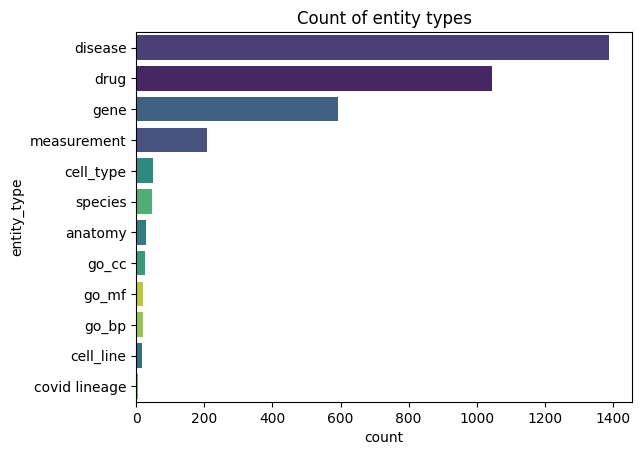

In [ ]:
title_txt = 'Count of entity types'
plot_entity_type(title_txt, replace_hcov_df)

The most frequently occurring concepts are 'disease', 'drug' and 'gene'. For BERN2 the order was 'drug', 'disease', and 'gene'.

KAZU also splits the gene ontology entity types into `go_bp`, `go_cc` and `go_mf` representing the Biological Process, Cellular Component and Molecular Function groups of GO.

### 7.1 Plot entities

In [ ]:
def plot_sentence_entity_counts(df):
    # Get the count of entities per 'idx'
    entity_counts = df.groupby('idx')['entity'].count()

    # Create a range of consecutive numbers from min to max of entity counts
    full_range = pd.Series(range(entity_counts.min(), entity_counts.max() + 1))

    # Compute the distribution of entity counts and reindex with the full range
    entity_count_distribution = entity_counts.value_counts().sort_index()

    # Reindex the distribution to include missing counts and fill missing values with 0
    entity_count_distribution = entity_count_distribution.reindex(full_range, fill_value=0)

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=entity_count_distribution.index, hue=entity_count_distribution.index, y=entity_count_distribution.values, palette='viridis', legend=False)
    plt.title('Number of Entities in Sentences', size=12)
    plt.xlabel('Number of Entities', size=10)
    plt.ylabel('Number of Sentences', size=10)
    plt.show()

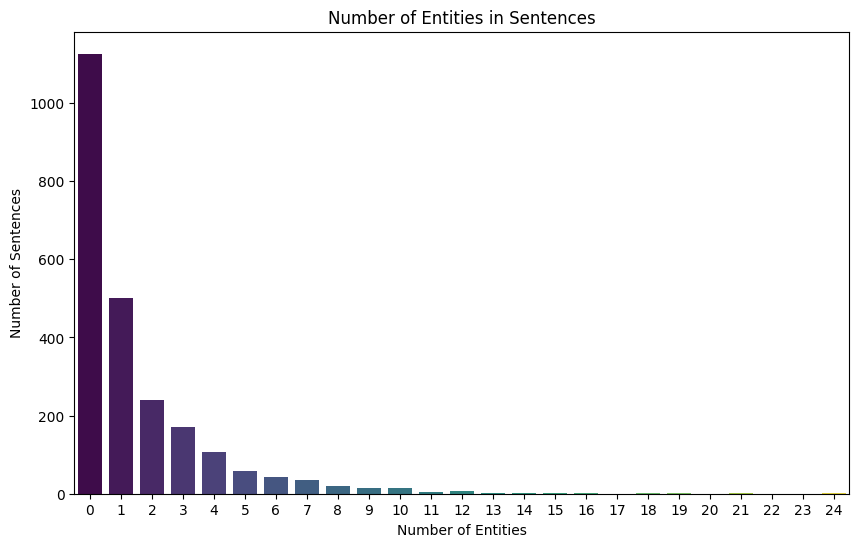

In [ ]:
plot_sentence_entity_counts(replace_hcov_df)

This dataset includes the sentences without labelled entities and it appears that most sentences do not actually contain a labelled entity.

We will identify the sentence with 24 entities which was also visualised when analysing the BERN2 data.

In [ ]:
# Filter the DataFrame to get rows from the sentence with 24 entities
sentence_with_24_entities = replace_hcov_df.groupby('idx').filter(lambda x: len(x) == 24)
sentence_with_24_entities

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
1673,NSP16,gene,NSP16,0,5,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1674,chembl:CHEMBL1535,drug,hydroxychloroquine,22,40,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1675,Arg6817,drug,Arg6817,53,60,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1676,Met6818,drug,Met6818,62,69,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1677,Leu6819,drug,Leu6819,71,78,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1678,Leu6820,drug,Leu6820,80,87,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1679,Tyr7020,drug,Tyr7020,89,96,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1680,Val7021,drug,Val7021,98,105,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1681,Asp7018,drug,Asp7018,107,114,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052
1682,Asp6942,drug,Asp6942,120,127,NSP16 interacted with hydroxychloroquine at re...,eca551a43a334a3a822c05cc5ef66c71,PMC9346052


In [ ]:
len(sentence_with_24_entities)

24

In [ ]:
# Print the full text of the sentence with 24 entities
sentence_with_24_entities.iloc[0]['text']

'NSP16 interacted with hydroxychloroquine at residues Arg6817, Met6818, Leu6819, Leu6820, Tyr7020, Val7021, Asp7018, and Asp6942 and with ritonavir at residues Phe314, Gln260, Arg259, Arg277, Phe274, Tyr333, Trp330, Trp301, Thr282, Gly284, Phe286, Leu291, and Val270.'

Not surprisingly, it is a long list of entities.



## 8. Create entities only datasets

We will create a subset of data which contains only sentences with one or more labelled entity.

In [ ]:
# Sum of missing values to calculate rows without entities
replace_hcov_df.entity.isnull().sum()

1136

In [ ]:
replace_hcov_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4583 entries, 0 to 4582
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3447 non-null   object
 1   entity_type  3447 non-null   object
 2   entity       3447 non-null   object
 3   span_start   3447 non-null   Int64 
 4   span_end     3447 non-null   Int64 
 5   text         4583 non-null   object
 6   idx          4583 non-null   object
 7   article_id   4583 non-null   object
dtypes: Int64(2), object(6)
memory usage: 295.5+ KB


In [ ]:
# Drop rows with null values
kazu_entities_only = replace_hcov_df.dropna()

In [ ]:
# Reset index
kazu_entities_only = kazu_entities_only.reset_index(drop=True)

In [ ]:
kazu_entities_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3447 non-null   object
 1   entity_type  3447 non-null   object
 2   entity       3447 non-null   object
 3   span_start   3447 non-null   Int64 
 4   span_end     3447 non-null   Int64 
 5   text         3447 non-null   object
 6   idx          3447 non-null   object
 7   article_id   3447 non-null   object
dtypes: Int64(2), object(6)
memory usage: 222.3+ KB


In [ ]:
with open('2024-05-10_kazu_entities_only_3447.pickle', 'wb') as f:
  pickle.dump(kazu_entities_only, f)

### 8.1 Single-entity sentence counts

We will get a count of unique sentences with at least one entity.

In [ ]:
# Count unique sentences
kazu_entities_only['idx'].nunique()

1224

In [ ]:
kazu_entities_only_unique_sents = kazu_entities_only['text'].unique()

In [ ]:
kazu_entities_only_unique_sents

array(['Since the 1990s, the repositioning of sildenafil for male erectile dysfunction and pulmonary hypertension, the development of a new efficacy of bupropion for smoking cessation, new applications of thalidomide for multiple myeloma, and chronic graft-versus-host disease have generated intense interest from pharmaceutical companies and academics.',
       'At the beginning of the 21st century, cheminformatics, bioinformatics, systems biology, genomics, polypharmacology, precision medicine, and other disciplines, combined with artificial intelligence, have developed rapidly.',
       'cheminformatics, bioinformatics, systems biology, genomics, polypharmacology, precision medicine, and other disciplines have promoted the generation of systematic computer methods to make the drug repositioning process cheaper and shorter.',
       ...,
       "The score for each drug is equal to the sum of all each drug's DGV scores.",
       'We used gene expression profiles of SARS-CoV-2 infected s

In [ ]:
with open('2024-10-29_kazu_entities_only_unique_sents_1224.pickle', 'wb') as f:
  pickle.dump(kazu_entities_only_unique_sents, f)

We will get a count of the number of unique entities in the sentences with at least one entity.

In [ ]:
# Count unique entities
kazu_entities_only['entity'].nunique()

1053

In [ ]:
kazu_entities_only_unique = kazu_entities_only['entity'].unique()

In [ ]:
kazu_entities_only_unique

array(['sildenafil', 'male erectile dysfunction',
       'pulmonary hypertension', ..., 'SARS-CoV-2 infected',
       'alveolar type II cells', 'African green monkey kidney cells'],
      dtype=object)

In [ ]:
with open('2024-10-29_kazu_entities_only_unique_1053.pickle', 'wb') as f:
  pickle.dump(kazu_entities_only_unique, f)

We will get a count of the unique entity types.

In [ ]:
# Count unique entity types
kazu_entities_only['entity_type'].nunique()

12

In [ ]:
# Array of unique entity types
kazu_entities_only['entity_type'].unique()

array(['drug', 'disease', 'measurement', 'gene', 'cell_line', 'anatomy',
       'cell_type', 'go_cc', 'species', 'covid lineage', 'go_bp', 'go_mf'],
      dtype=object)

### 8.2 Embed labels in single-entity sentences

We will create a dataset of unique sentences containing at least one entity and embed the `entity_type` labels in each sentence using parentheses as delimiters in the format `(entity_type: entity)`, for example `(drug: Baricitinib) was selected as a potential repurposed drug against (disease: SARS-CoV-2) through an artificial intelligence algorithm.`

In [ ]:
# load entities only dataset
with open('2024-05-10_kazu_entities_only_3447.pickle', 'rb') as f:
  kazu_entities_only = pickle.load(f)

In [ ]:
# create copy of DataFrame
kazu_entities_only_delimiters = kazu_entities_only.copy()

We will define a function to add parenthesis delimiters around entities and then add a `text_ner` column to the DataFrame.

In [ ]:
# Create a dictionary to hold sentences and their corresponding entities with spans
sentences_entities = {}

for _, row in kazu_entities_only_delimiters.iterrows():
    text = row['text']
    entity = row['entity']
    span_start = row['span_start']
    span_end = row['span_end']
    if text not in sentences_entities:
        sentences_entities[text] = []
    sentences_entities[text].append((entity, span_start, span_end))

# Function to add delimiters around entities in a sentence using their spans
def add_delimiters(sentence, entities_with_spans):
    # Sort entities by span_start in descending order
    entities_with_spans = sorted(entities_with_spans, key=lambda x: x[1], reverse=True)
    for entity, span_start, span_end in entities_with_spans:
        sentence = sentence[:span_start] + f'({entity})' + sentence[span_end:]
    return sentence

# Create a new column with sentences having delimiters around entities
kazu_entities_only_delimiters['text_ner'] = kazu_entities_only_delimiters['text'].apply(
    lambda x: add_delimiters(x, sentences_entities[x])
)

In [ ]:
with open('2024-06-10_kazu_entities_only_delimiters_v2.pickle', 'wb') as f:
  pickle.dump(kazu_entities_only_delimiters, f)

In [ ]:
kazu_entities_only_delimiters.to_csv('2024-06-10_kazu_entities_only_delimiters_v2.csv', index=False)

In [ ]:
kazu_entities_only_delimiters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3447 non-null   object
 1   entity_type  3447 non-null   object
 2   entity       3447 non-null   object
 3   span_start   3447 non-null   Int64 
 4   span_end     3447 non-null   Int64 
 5   text         3447 non-null   object
 6   idx          3447 non-null   object
 7   article_id   3447 non-null   object
 8   text_ner     3447 non-null   object
dtypes: Int64(2), object(7)
memory usage: 249.2+ KB


In [ ]:
kazu_entities_only_delimiters

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id,text_ner
0,chembl:CHEMBL192,drug,sildenafil,38,48,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161,"Since the 1990s, the repositioning of (sildena..."
1,HP:0100639,disease,male erectile dysfunction,53,78,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161,"Since the 1990s, the repositioning of (sildena..."
2,MONDO:0005149,disease,pulmonary hypertension,83,105,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161,"Since the 1990s, the repositioning of (sildena..."
3,chembl:CHEMBL894,drug,bupropion,144,153,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161,"Since the 1990s, the repositioning of (sildena..."
4,chembl:CHEMBL468,drug,thalidomide,197,208,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161,"Since the 1990s, the repositioning of (sildena..."
...,...,...,...,...,...,...,...,...,...
3442,STATO:0000569,measurement,score,4,9,The score for each drug is equal to the sum of...,f06e07ee624e49de824cb35e524cef19,PMC9556799,The (score) for each drug is equal to the sum ...
3443,covid,disease,SARS-CoV-2 infected,36,55,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799,We used gene expression profiles of (SARS-CoV-...
3444,CL:0002063,cell_type,alveolar type II cells,89,111,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799,We used gene expression profiles of (SARS-CoV-...
3445,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799,We used gene expression profiles of (SARS-CoV-...


In [ ]:
kazu_entities_only_delimiters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3447 non-null   object
 1   entity_type  3447 non-null   object
 2   entity       3447 non-null   object
 3   span_start   3447 non-null   Int64 
 4   span_end     3447 non-null   Int64 
 5   text         3447 non-null   object
 6   idx          3447 non-null   object
 7   article_id   3447 non-null   object
 8   text_ner     3447 non-null   object
dtypes: Int64(2), object(7)
memory usage: 249.2+ KB


We will define a function to add parenthesis delimiters and entity type labels around entities and then add a `text_ner_labels` column to the DataFrame.

In [ ]:
# Create a dictionary to hold sentences and their corresponding entities with spans and types
sentences_entities = {}

for _, row in kazu_entities_only_delimiters.iterrows():
    text = row['text']
    entity = row['entity']
    entity_type = row['entity_type']
    span_start = row['span_start']
    span_end = row['span_end']
    if text not in sentences_entities:
        sentences_entities[text] = []
    sentences_entities[text].append((entity, entity_type, span_start, span_end))

# Function to add delimiters and labels around entities in a sentence using their spans
def add_delimiters_with_labels(sentence, entities_with_spans_types):
    # Sort entities by span_start in descending order
    entities_with_spans_types = sorted(entities_with_spans_types, key=lambda x: x[2], reverse=True)
    for entity, entity_type, span_start, span_end in entities_with_spans_types:
        sentence = sentence[:span_start] + f'({entity_type}: {entity})' + sentence[span_end:]
    return sentence

kazu_entities_only_delimiters['text_ner_label'] = kazu_entities_only_delimiters['text'].apply(
    lambda x: add_delimiters_with_labels(x, sentences_entities[x])
)

In [ ]:
kazu_entities_only_delimiters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   entity_id       3447 non-null   object
 1   entity_type     3447 non-null   object
 2   entity          3447 non-null   object
 3   span_start      3447 non-null   Int64 
 4   span_end        3447 non-null   Int64 
 5   text            3447 non-null   object
 6   idx             3447 non-null   object
 7   article_id      3447 non-null   object
 8   text_ner        3447 non-null   object
 9   text_ner_label  3447 non-null   object
dtypes: Int64(2), object(8)
memory usage: 276.2+ KB


In [ ]:
with open('2024-06-10_kazu_entities_only_text_ner_labels.pickle', 'wb') as f:
  pickle.dump(kazu_entities_only_delimiters, f)

In [ ]:
kazu_entities_only_delimiters.to_csv('2024-06-10_kazu_entities_only_text_ner_labels.csv', index=False)

We will drop duplicate rows and keep the unique sentences with delimiters.

In [ ]:
unique_rows_ner = kazu_entities_only_delimiters.drop_duplicates(subset=['text', 'text_ner', 'text_ner_label', 'idx', 'article_id']).reset_index(drop=True)

unique_rows_ner_df = unique_rows_ner[['text', 'text_ner', 'text_ner_label', 'idx', 'article_id']]

In [ ]:
len(unique_rows_ner_df)

1224

In [ ]:
with open('2024-06-10_text_ner_labels_1224.pickle', "wb") as f:
    pickle.dump(unique_rows_ner_df, f)

In [ ]:
unique_rows_ner_df.to_csv('2024-06-10_text_ner_labels_1224.csv', index=False)

Some manual postprocessing to the csv was required.

In [ ]:
text_ner_labels_data =  pd.read_csv('2024-06-10_text_ner_labels_1224_edited.csv')
text_ner_labels_data

,text,text_ner,text_ner_label,idx,article_id
0,"Since the 1990s, the repositioning of sildenaf...","Since the 1990s, the repositioning of (sildena...","Since the 1990s, the repositioning of (drug: s...",22200652f00d4d5fb5875f619734eaed,PMC9549161
1,"At the beginning of the 21st century, cheminfo...","At the beginning of the 21st century, cheminfo...","At the beginning of the 21st century, cheminfo...",45575790fc88453a90d6e15b0474e89d,PMC9549161
2,"cheminformatics, bioinformatics, systems biolo...","cheminformatics, bioinformatics, systems biolo...","cheminformatics, bioinformatics, systems biolo...",ac22ae2fbeb14ca5baf01f3b0022cd57,PMC9549161
3,"Today, drug repositioning is increasingly prom...","Today, drug repositioning is increasingly prom...","Today, drug repositioning is increasingly prom...",ae1f33d77559408bb43f914ac3aa8b88,PMC9549161
4,The bibliometric approach can solve the aforem...,The bibliometric approach can solve the aforem...,The bibliometric approach can solve the aforem...,82ab09f0f9bd4539b612bc196d0aa7b8,PMC9549161
...,...,...,...,...,...
1219,"For mapping score, the score is set as the inv...","For mapping (score), the (score) is set as the...","For mapping (measurement: score), the (measure...",1fc0f648521b4af882a2f95db57e947b,PMC9556799
1220,"For host gene score, host gene score got 1 poi...","For host gene (score), host gene (score) got 1...","For host gene (measurement: score), host gene ...",400fdc45284e4336a9d4d2ed0a88e928,PMC9556799
1221,The score for each drug is equal to the sum of...,The (score) for each drug is equal to the sum ...,The (measurement: score) for each drug is equa...,f06e07ee624e49de824cb35e524cef19,PMC9556799
1222,We used gene expression profiles of SARS-CoV-2...,We used gene expression profiles of (SARS-CoV-...,We used gene expression profiles of (disease: ...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799


In [ ]:
text_ner_labels_data.to_json('2024-06-10_text_ner_labels_1224_edited.json', orient='records')

In [ ]:
# Load JSON file
with open('2024-06-10_text_ner_labels_1224_edited.json', 'r') as f:
    text_ner_labels_data = json.load(f)

In [ ]:
# display sample sentence
text_ner_labels_data[1219]

{'text': 'For mapping score, the score is set as the inverse of the number of genes.',
 'text_ner': 'For mapping (score), the (score) is set as the inverse of the number of genes.',
 'text_ner_label': 'For mapping (measurement: score), the (measurement: score) is set as the inverse of the number of genes.',
 'idx': '1fc0f648521b4af882a2f95db57e947b',
 'article_id': 'PMC9556799'}

### 8.3 Multiple-entity sentences


We will also keep a subset of sentences with two or more entities which could be used for sentence-level relation extraction, as there would need to be a minimum of two entities in a sentence for there to be a relation between them.



In [ ]:
kazu_multiple_entities = kazu_entities_only[kazu_entities_only.duplicated('idx', keep=False)]

In [ ]:
len(kazu_multiple_entities)

2946

In [ ]:
kazu_multiple_entities = kazu_multiple_entities.reset_index(drop=True)

In [ ]:
kazu_multiple_entities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    2946 non-null   object
 1   entity_type  2946 non-null   object
 2   entity       2946 non-null   object
 3   span_start   2946 non-null   Int64 
 4   span_end     2946 non-null   Int64 
 5   text         2946 non-null   object
 6   idx          2946 non-null   object
 7   article_id   2946 non-null   object
dtypes: Int64(2), object(6)
memory usage: 190.0+ KB


In [ ]:
kazu_multiple_entities

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
0,chembl:CHEMBL192,drug,sildenafil,38,48,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
1,HP:0100639,disease,male erectile dysfunction,53,78,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
2,MONDO:0005149,disease,pulmonary hypertension,83,105,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
3,chembl:CHEMBL894,drug,bupropion,144,153,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
4,chembl:CHEMBL468,drug,thalidomide,197,208,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
...,...,...,...,...,...,...,...,...
2941,STATO:0000569,measurement,score,14,19,"For host gene score, host gene score got 1 poi...",400fdc45284e4336a9d4d2ed0a88e928,PMC9556799
2942,STATO:0000569,measurement,score,31,36,"For host gene score, host gene score got 1 poi...",400fdc45284e4336a9d4d2ed0a88e928,PMC9556799
2943,covid,disease,SARS-CoV-2 infected,36,55,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799
2944,CL:0002063,cell_type,alveolar type II cells,89,111,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799


In [ ]:
with open('2024-05-10_kazu_multiple_entities_2946.pickle', 'wb') as f:
  pickle.dump(kazu_multiple_entities, f)

We will get a count of unique sentences with more than one entity.

In [ ]:
# Count unique sentences with > 1 entity
kazu_multiple_entities['idx'].nunique()

723

In [ ]:
kazu_multi_ents_unique_sents = kazu_multiple_entities['text'].unique()

In [ ]:
kazu_multi_ents_unique_sents

array(['Since the 1990s, the repositioning of sildenafil for male erectile dysfunction and pulmonary hypertension, the development of a new efficacy of bupropion for smoking cessation, new applications of thalidomide for multiple myeloma, and chronic graft-versus-host disease have generated intense interest from pharmaceutical companies and academics.',
       'Today, drug repositioning is increasingly prominent in the development of drugs for a variety of neurological diseases, cancer, rare diseases, and infectious diseases.',
       'the top 30 most used author keywords include five diseases COVID-19/SARS-CoV-2/Coronavirus, Cancer, Alzheimer’s disease, Breast cancer, and Chagas disease.',
       'Drug names appear four times, Antiviral drugs, Metformin, Statins, and Antibiotics, which reveal the diseases and applications to which drugs were often repositioned during recent years.',
       'In the context of the pandemic in that year, there was a surge in research on the subject, with

In [ ]:
with open('2024-05-10_kazu_multi_ents_unique_sents_723.pickle', 'wb') as f:
  pickle.dump(kazu_multi_ents_unique_sents, f)

We will get a count of the number of unique entities in the sentences with more than one entity.

In [ ]:
# Count unique entities
kazu_multiple_entities['entity'].nunique()

855

In [ ]:
kazu_multi_ents_unique = kazu_multiple_entities['entity'].unique()

In [ ]:
kazu_multi_ents_unique

array(['male erectile dysfunction', 'pulmonary hypertension', 'bupropion',
       'thalidomide', 'multiple myeloma',
       'chronic graft-versus-host disease', 'cancer', 'rare diseases',
       'infectious diseases', 'SARS-CoV-2', 'Coronavirus', 'Cancer',
       'Alzheimer’s disease', 'Breast cancer', 'Chagas disease',
       'Statins', 'COVID-19', 'clonidine', 'chloroquine',
       'hydroxychloroquine', 'coronavirus', 'disulfiram', 'p97 segregase',
       'NPL4', 'tumors', 'Metformin', 'HIV', 'plagued', 'Zika virus',
       'coronaviruses', 'mortality', 'genetically related diseases',
       'epidemic diseases', 'MERS‐CoV', 'CoVs', 'SARS‐CoV‐2',
       'severe acute respiratory syndrome CoV', 'respiratory illness',
       'influenza', 'Ebola viral diseases', 'foscarnet', 'tenofovir',
       'sofosbuvir', 'uprifosbuvir', 'phosphoramide', 'phosphate',
       'azole', 'hepatitis', 'COVID‐19', 'remdesivir', 'drug resistance',
       'molnupiravir', 'paxlovid 3c‐like protease', 'hepatitis

In [ ]:
with open('2024-05-10_kazu_multi_ents_unique_855.pickle', 'wb') as f:
  pickle.dump(kazu_multi_ents_unique, f)

We will get a count of the unique entity types.

In [ ]:
# Count unique entity types
kazu_multiple_entities['entity_type'].nunique()

11

In [ ]:
# Array of unique entity types
kazu_multiple_entities['entity_type'].unique()

array(['disease', 'drug', 'gene', 'measurement', 'anatomy', 'cell_type',
       'go_cc', 'species', 'cell_line', 'go_bp', 'go_mf'], dtype=object)

We can see that the entity type 'covid lineage' is missing. There were very few of these and none in sentences with more than one entity.

### References

* Yoon, W. et al. (2022). Biomedical NER for the Enterprise with Distillated BERN2 and the Kazu Framework. In *Proceedings of the 2022 Conference on Empirical Methods in Natural Language Processing: Industry Track*, pages 619-626, Abu Dhabi, UAE. Association for Computational Linguistics. [doi:10.18653/v1/2022.emnlp-industry.63](https://doi.org/10.18653/v1/2022.emnlp-industry.63)


* https://github.com/AstraZeneca/KAZU

* KAZU documentation: https://astrazeneca.github.io/KAZU/

* KAZU web API demo: http://kazu.korea.ac.kr/api/docs#/

* BioNER spaCy Language component: https://github.com/librairy/bio-ner/blob/main/bionlp/NER_processing.py



